
Sfera di Hill della Terra ha raggio: 1471242.3362534388 km (794407.60 nmi)
Sfera di Hill della Luna ha raggio: 58153.9994772027 km (31400.66 nmi)

Sfera di Laplace (SOI) della Terra ha raggio: 924402.7509079104 km (499137.74 nmi)
Sfera di Laplace (SOI) della Luna ha raggio: 66193.29744071953 km (35741.53 nmi)
Plotting position


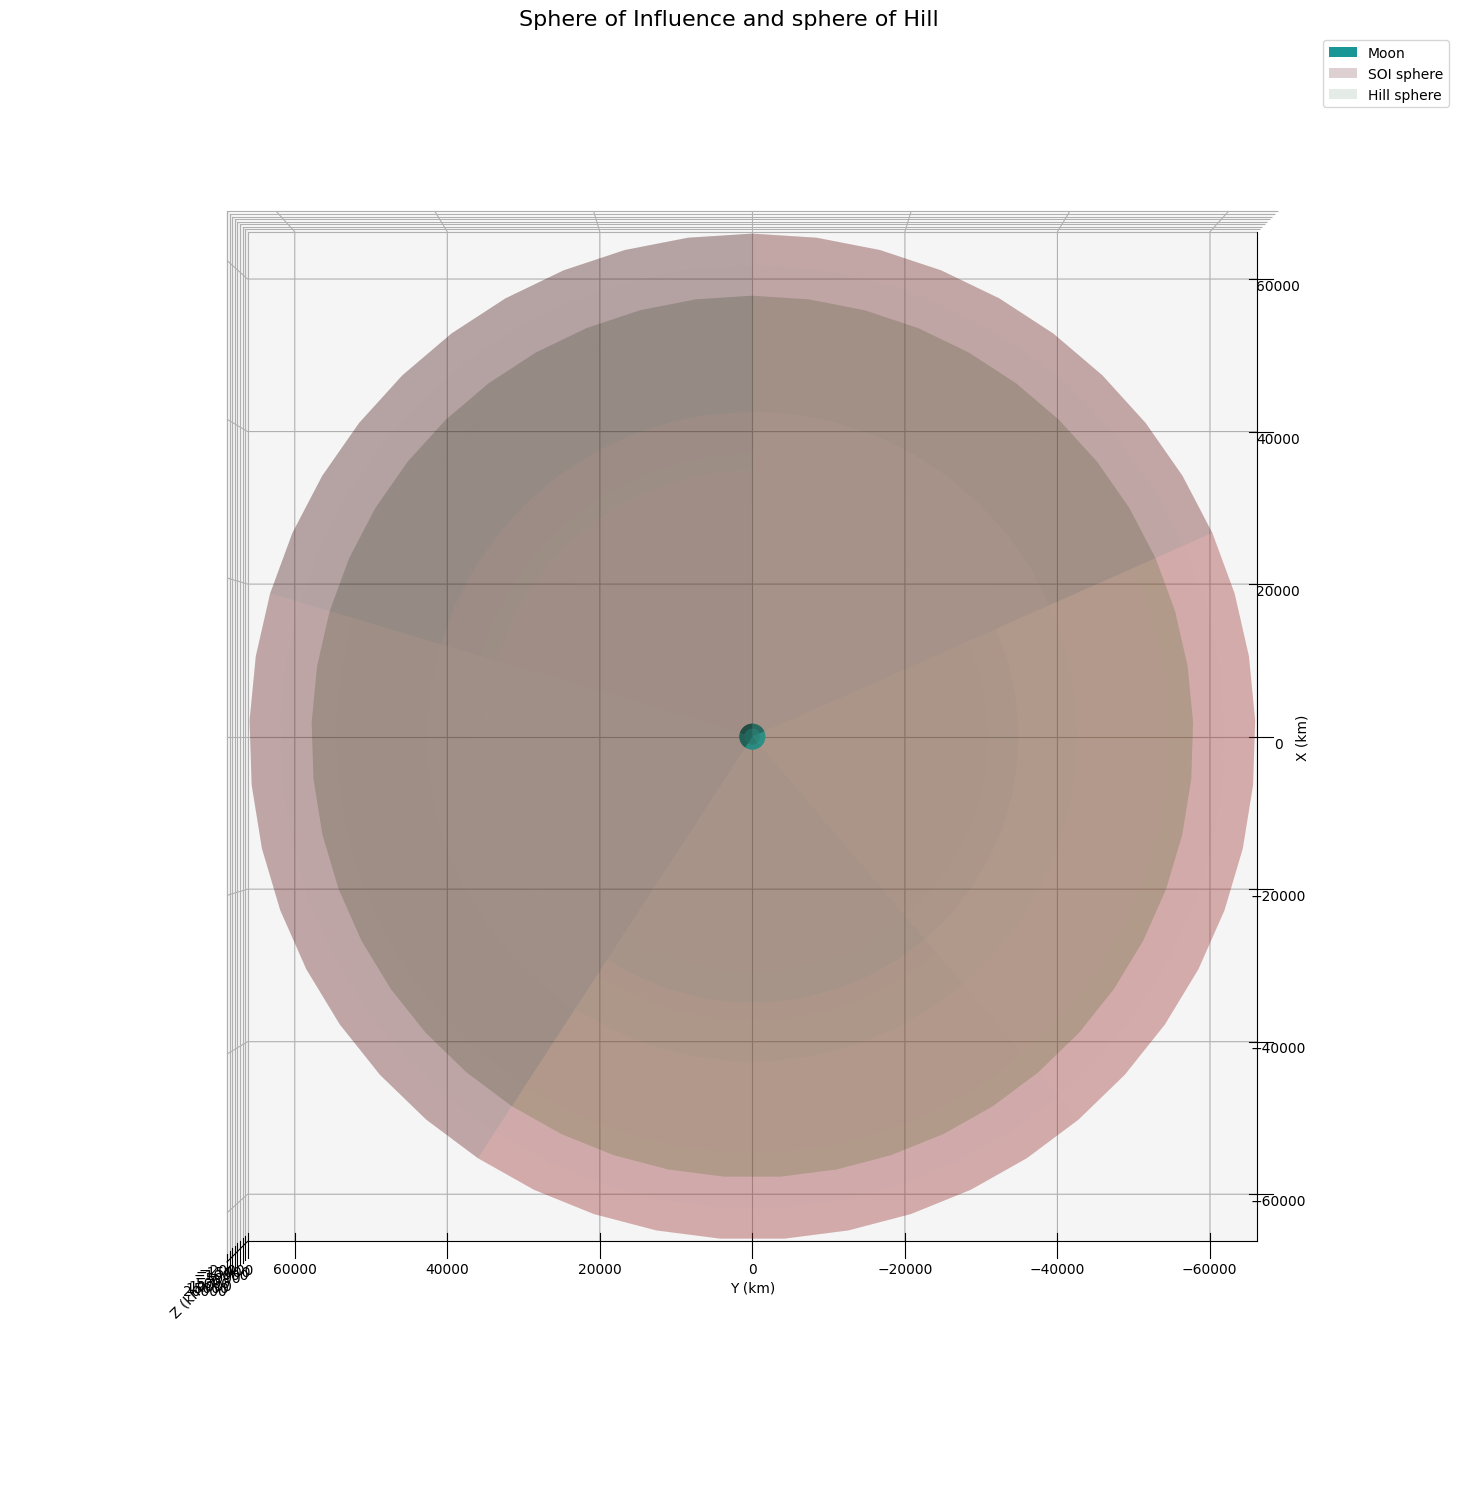

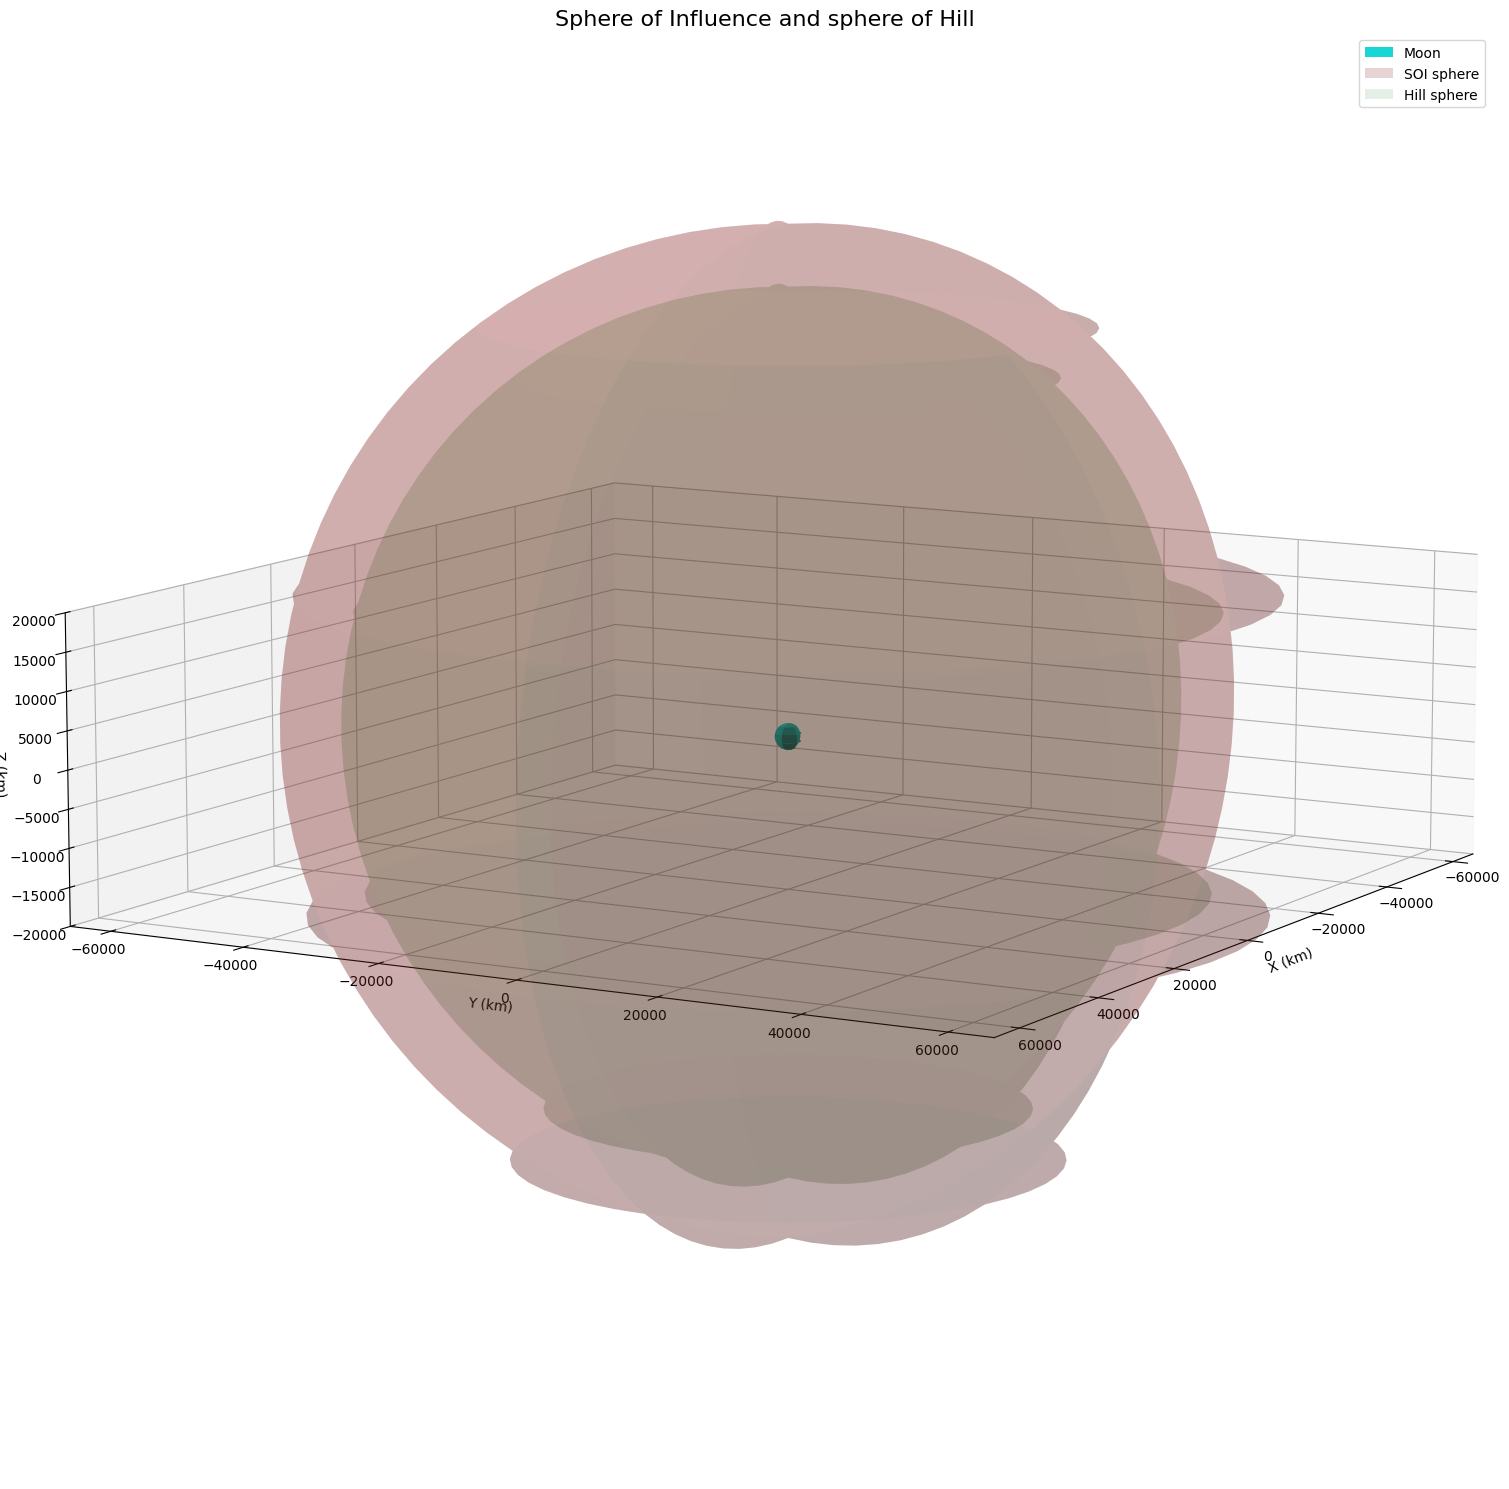

In [5]:
# ref data https://svs.gsfc.nasa.gov/4791/#photos
# get startedpyorb  https://danielk.developer.irf.se/pyorb/notebooks/getting_started_tutorial.html

import matplotlib.pyplot as plt_SOI
import matplotlib.pyplot as plt_stack
import numpy as np

MU_MOON = 4902.8  # km^3/s^2
R_MOON = 1737.4 # km

m_s = 1.989e30
a = 384400 #km
m_m = 7.346e22
m_e = 5.97e24

PI = np.pi

# Planet data: [Mass (kg), Radius (m), a (Km), e]
# Masses are in kg, Radii are converted from km to meters.
planet_data = {
    "Earth": [5.97e24, 6371e3, 149597870, 0.0167],
    "Moon": [7.346e22, R_MOON * 1000, 384400, 0.0549],
}

From_km_nautical_mile = 0.539957
From_km_sec_ft_sec = 3280.84

def calculate_hill_sphere(planet_mass, semi_major_axis, reference_planet_mass, eccentricity):
    hill_sphere_radius = (1 - eccentricity) * semi_major_axis * (planet_mass / (3 * reference_planet_mass))**(1/3)
    return hill_sphere_radius


def calculate_laplace_sphere(planet_mass, semi_major_axis, reference_planet_mass):
    #laplace_sphere_radius = (0.9431) * semi_major_axis * (planet_mass / (reference_planet_mass))**(2/5)
    laplace_sphere_radius = semi_major_axis * (planet_mass / (reference_planet_mass))**(2/5)
    return laplace_sphere_radius


def plot_SOI(central_body_radius, SOI_radius, HILL_radius):

    # Plot the central body (e.g., Earth) as a sphere
    u = np.linspace(0, 2 * np.pi, 50) # Azimuthal angle
    v = np.linspace(0, np.pi, 50)     # Polar angle
    x_moon = central_body_radius * np.outer(np.cos(u), np.sin(v))
    y_moon = central_body_radius * np.outer(np.sin(u), np.sin(v))
    z_moon = central_body_radius * np.outer(np.ones(np.size(u)), np.cos(v))

    x_SOI = SOI_radius * np.outer(np.cos(u), np.sin(v))
    y_SOI = SOI_radius * np.outer(np.sin(u), np.sin(v))
    z_SOI = SOI_radius * np.outer(np.ones(np.size(u)), np.cos(v))

    x_HILL = HILL_radius * np.outer(np.cos(u), np.sin(v))
    y_HILL = HILL_radius * np.outer(np.sin(u), np.sin(v))
    z_HILL = HILL_radius * np.outer(np.ones(np.size(u)), np.cos(v))

    angles = [(90, 180, 0), (10, 30, 0)]
    print(f"Plotting position")
    for angle in angles:
        fig = plt_SOI.figure(figsize=(20,15))
        ax = fig.add_subplot(projection='3d')
        ax.view_init(elev = angle[0], azim = angle[1], roll = angle[2])
        ax.plot_surface(x_moon, y_moon, z_moon,  cstride=10, alpha=0.9, label='Moon', color='cyan')
        ax.plot_surface(x_SOI, y_SOI, z_SOI,  cstride=10, alpha=0.2, label='SOI sphere', color='brown')
        ax.plot_surface(x_HILL, y_HILL, z_HILL,  cstride=10, alpha=0.1, label='Hill sphere', color='green')

        limit_axis = max(HILL_radius, SOI_radius)
        ax.set_xlim([-limit_axis, limit_axis])
        ax.set_ylim([-limit_axis, limit_axis])
        ax.set_zlim([-20000, 20000])

        ax.set_xlabel('X (km)')
        ax.set_ylabel('Y (km)')
        ax.set_zlabel('Z (km)')
        ax.legend()
        ax.set_aspect('equal', adjustable='box') # 'equal' ensures correct proportions
        plt_SOI.grid(True)
        plt_SOI.title('Sphere of Influence and sphere of Hill ', fontsize = '16')
        plt_SOI.savefig(f'SOI_HILL_Sphere_{angle}.png')
        plt_SOI.tight_layout()
        plt_SOI.tight_layout()

if __name__ == "__main__":
    print ("")
    r_hill = calculate_hill_sphere(planet_data['Earth'][0], planet_data['Earth'][2], m_s, planet_data['Earth'][3])
    print (f"Sfera di Hill della Terra ha raggio: {r_hill} km ({r_hill * From_km_nautical_mile:.2f} nmi)")
    r_hill = calculate_hill_sphere(planet_data['Moon'][0], planet_data['Moon'][2], planet_data['Earth'][0], planet_data['Moon'][3])
    print (f"Sfera di Hill della Luna ha raggio: {r_hill} km ({r_hill * From_km_nautical_mile:.2f} nmi)")
    print ("")
    r_laplace = calculate_laplace_sphere(planet_data['Earth'][0], planet_data['Earth'][2], m_s)
    print (f"Sfera di Laplace (SOI) della Terra ha raggio: {r_laplace} km ({r_laplace * From_km_nautical_mile:.2f} nmi)")
    r_laplace = calculate_laplace_sphere(planet_data['Moon'][0], planet_data['Moon'][2], planet_data['Earth'][0])
    print (f"Sfera di Laplace (SOI) della Luna ha raggio: {r_laplace} km ({r_laplace * From_km_nautical_mile:.2f} nmi)")

    plot_SOI(R_MOON, r_laplace, r_hill)

Orbital parameters:
Eccentricity: 1.446, Perifocal Distance: 1988.800 km, Inclination: 173.700, Argument of Periapsis: 28.700, Longitude of the Ascending Node: -150.740
Semi-major axis hyperbola: -4457.194 km Radius Moon: 1737.400 km
Maximum velocity: 2.46 km/s   8057.74 ft/s
Pericynthius: 251.40 km


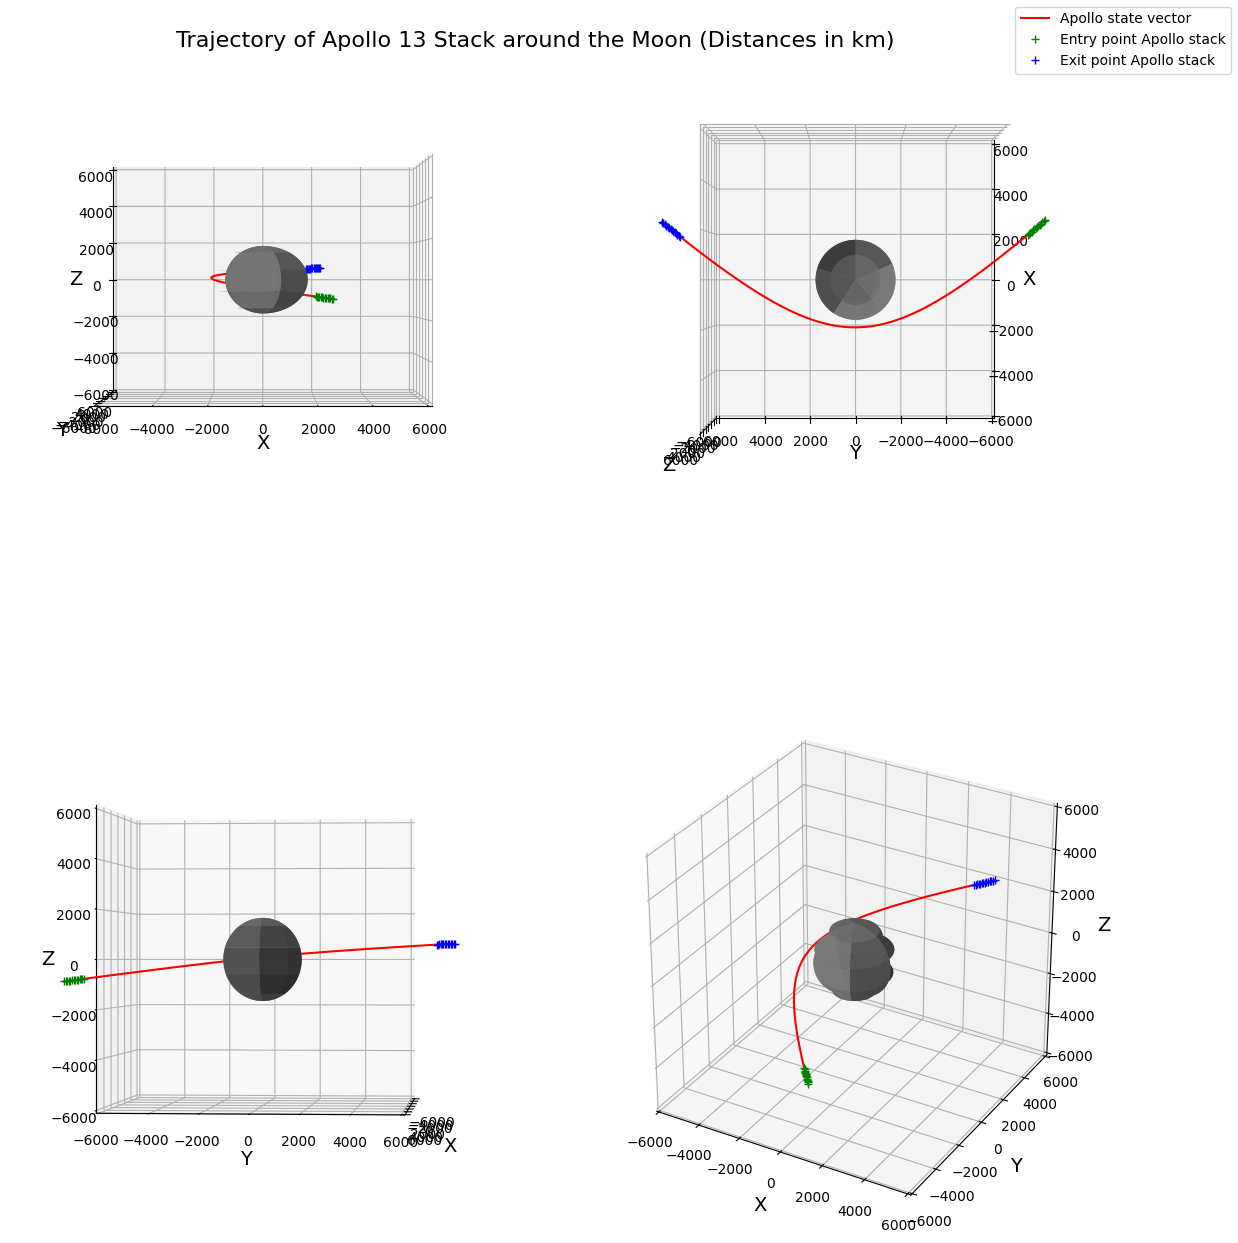

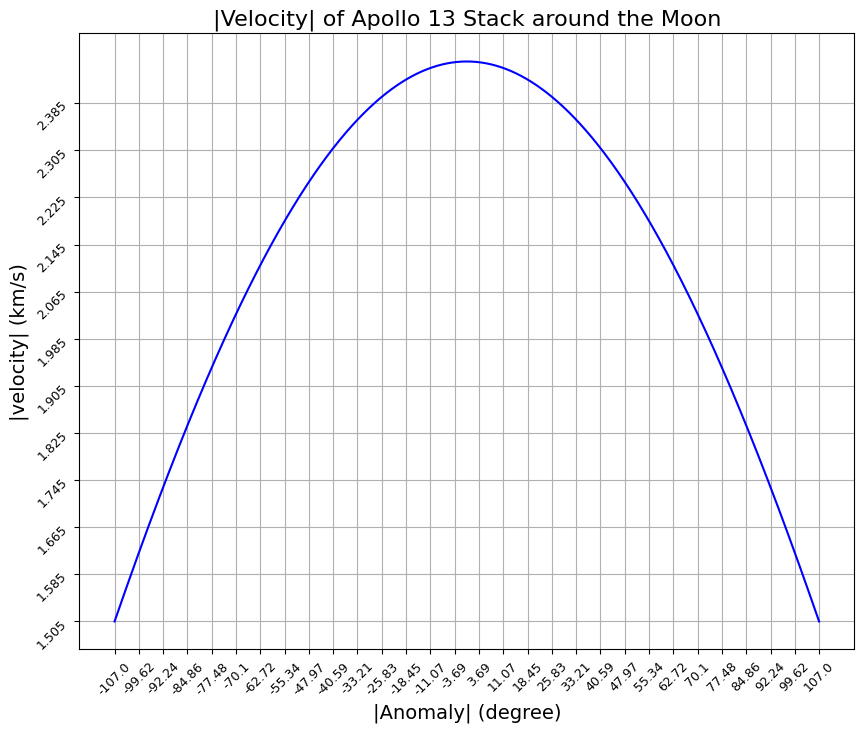

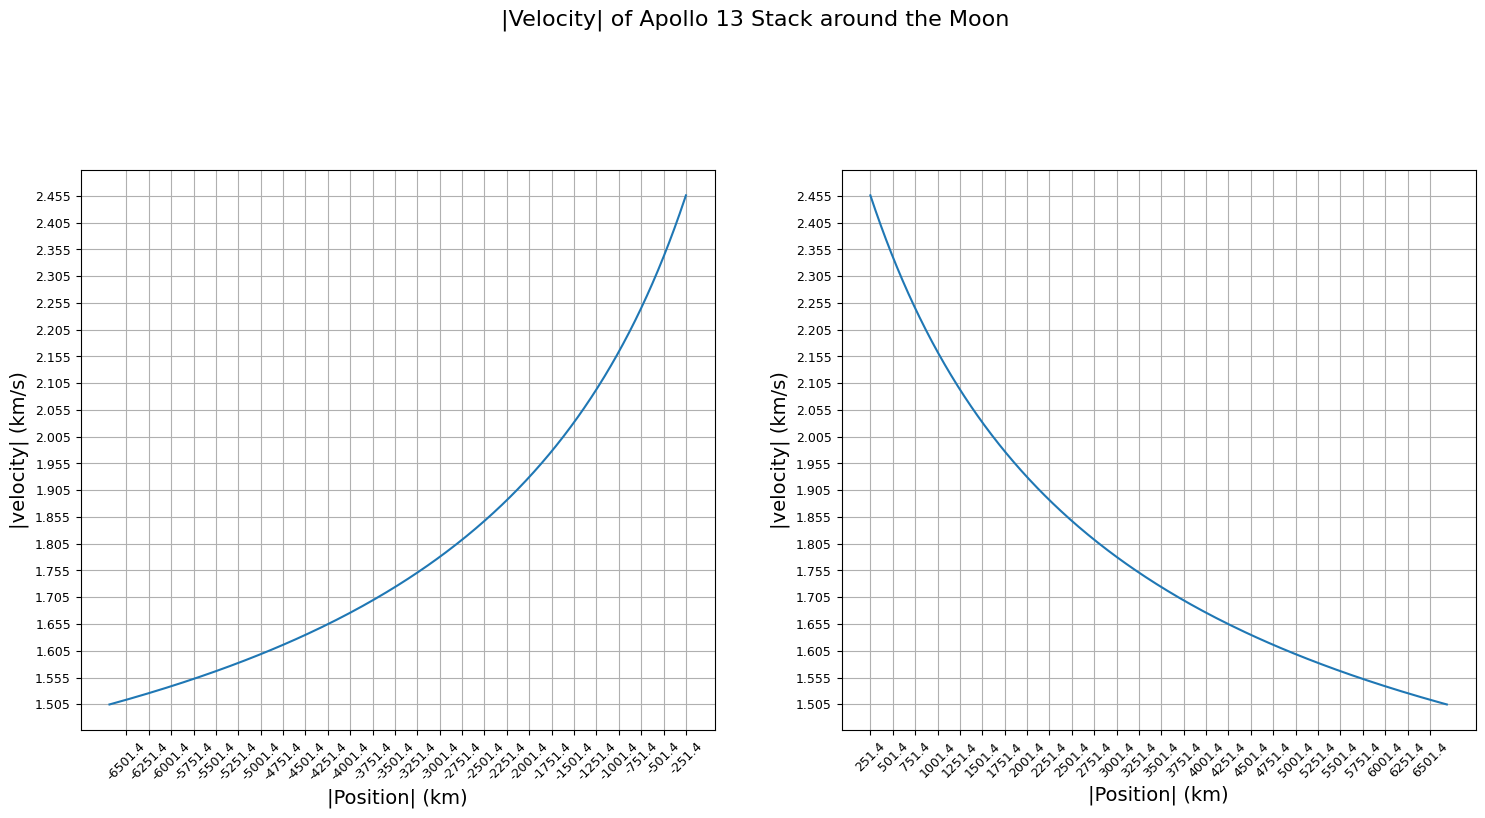

In [6]:
import matplotlib.pyplot as plt_3d_stack
import matplotlib.pyplot as plt_2d_stack
import matplotlib.pyplot as plt_velocity
import numpy as np
import pyorb

num = 1000

ecc = 1.4462
_p = 1988.8
_a = _p / (ecc - 1.0)
_i = 173.7
_omega = 28.7
theta_inf = pyorb.kepler.true_of_the_asymptote(e=ecc, degrees=True)
theta_inf *= 0.8
_Omega = -150.74

print (f'Orbital parameters:')
print (f'Eccentricity: {ecc:.3f}, Perifocal Distance: {_p:.3f} km, Inclination: {_i:.3f}, Argument of Periapsis: {_omega:.3f}, Longitude of the Ascending Node: {_Omega:.3f}')
print (f'Semi-major axis hyperbola: -{_a:.3f} km Radius Moon: {R_MOON:.3f} km')
orb = pyorb.Orbit(
    M0 = 7.34767309e22, # kg
    G = pyorb.get_G(length='km', mass='kg', time='s'),
    a = _a,
    e = ecc,
    i = _i,
    omega = _omega,
    Omega = _Omega,
    anom = np.linspace(-theta_inf, theta_inf, num=num),
    degrees = True,
    num = num,
    type = 'true',
)

r = orb.r
v = orb.v

legend_label = ['Apollo state vector', "Entry point Apollo stack", "Exit point Apollo stack"]
fig = plt_3d_stack.figure(figsize=(14, 14))
ax = fig.add_subplot(221, projection='3d')
ax.plot(r[0, :], r[1, :], r[2, :], '-r')
u_sphere = np.linspace(0, 2 * np.pi, 50) # Azimuthal angle
v_sphere = np.linspace(0, np.pi, 50)     # Polar angle
x_moon = R_MOON * np.outer(np.cos(u_sphere), np.sin(v_sphere))
y_moon = R_MOON * np.outer(np.sin(u_sphere), np.sin(v_sphere))
z_moon = R_MOON * np.outer(np.ones(np.size(u_sphere)), np.cos(v_sphere))
enter_limit_point = int(num/70)
exit_limit_point = r.shape[1] - enter_limit_point
ax.plot(r[0, 0:enter_limit_point], r[1, 0:enter_limit_point], r[2, 0:enter_limit_point], '+g')
ax.plot(r[0, exit_limit_point:], r[1, exit_limit_point:], r[2, exit_limit_point:], '+b')
ax.plot_surface(x_moon, y_moon, z_moon,  cstride=10, alpha=0.9, label='Moon', color='grey')
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
ax.set_zlabel('Z', fontsize=14)
xyzlim = np.array([ax.get_xlim3d(),ax.get_ylim3d(),ax.get_zlim3d()]).T
XYZlim = [min(xyzlim[0])/3*2, max(xyzlim[1])/3*2]
ax.set_xlim3d(XYZlim)
ax.set_ylim3d(XYZlim)
ax.set_zlim3d(XYZlim)

ax.view_init(0, -90, 0)
ax = fig.add_subplot(222, projection='3d')
ax.plot(r[0, :], r[1, :], r[2, :], '-r')
ax.plot(r[0, 0:enter_limit_point], r[1, 0:enter_limit_point], r[2, 0:enter_limit_point], '+g')
ax.plot(r[0, exit_limit_point:], r[1, exit_limit_point:], r[2, exit_limit_point:], '+b')
ax.plot_surface(x_moon, y_moon, z_moon,  cstride=10, alpha=0.9, color='grey')
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
ax.set_zlabel('Z', fontsize=14)
ax.set_xlim3d(XYZlim)
ax.set_ylim3d(XYZlim)
ax.set_zlim3d(XYZlim)
ax.set_aspect('equal', 'box')

ax.view_init(90, 180, 0)
ax = fig.add_subplot(223, projection='3d')
ax.plot(r[0, :], r[1, :], r[2, :], '-r')
ax.plot(r[0, 0:enter_limit_point], r[1, 0:enter_limit_point], r[2, 0:enter_limit_point], '+g')
ax.plot(r[0, exit_limit_point:], r[1, exit_limit_point:], r[2, exit_limit_point:], '+b')
ax.plot_surface(x_moon, y_moon, z_moon,  cstride=10, alpha=0.9, color='grey')
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
ax.set_zlabel('Z', fontsize=14)
ax.set_xlim3d(XYZlim)
ax.set_ylim3d(XYZlim)
ax.set_zlim3d(XYZlim)
ax.set_aspect('equal', 'box')

ax.view_init(0, 5, 0)
ax = fig.add_subplot(224, projection='3d')
ax.plot(r[0, :], r[1, :], r[2, :], '-r')
ax.plot(r[0, 0:enter_limit_point], r[1, 0:enter_limit_point], r[2, 0:enter_limit_point], '+g')
ax.plot(r[0, exit_limit_point:], r[1, exit_limit_point:], r[2, exit_limit_point:], '+b')
ax.plot_surface(x_moon, y_moon, z_moon,  cstride=10, alpha=0.9, color='grey')
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
ax.set_zlabel('Z', fontsize=14)
ax.set_xlim3d(XYZlim)
ax.set_ylim3d(XYZlim)
ax.set_zlim3d(XYZlim)
ax.set_aspect('equal')
fig.suptitle('Trajectory of Apollo 13 Stack around the Moon (Distances in km)', fontsize = '16')
fig.subplots_adjust(top=1)
fig.legend(legend_label, fontsize = '10')
#plt_3d_stack.show()
plt_3d_stack.savefig('Apollo_13_Stack_around_Moon.png')

k_x = np.sqrt(np.square(r[0, :]) + np.square(r[1, :]) + np.square(r[2, :]))
pericynthium = min(k_x) - R_MOON
k_x [np.where(k_x < 0)] += R_MOON
k_x [np.where(k_x >= 0)] -= R_MOON

# plot velocity vs mean anomaly

fig_, ax = plt_2d_stack.subplots(figsize=(10, 8))
anomaly_Xticks = np.linspace(round (min (orb.true_anomaly), 2), round (max (orb.true_anomaly), 2), 30)
anomaly_Xticks = np.round(anomaly_Xticks, 2)
listOf_Yticks = np.arange(min (orb.velocity), max(orb.velocity), step = 0.080)
listOf_Yticks = np.round(listOf_Yticks, 3)
plt_2d_stack.yticks(listOf_Yticks, listOf_Yticks, fontsize='9', rotation=45)
plt_2d_stack.xticks(anomaly_Xticks, anomaly_Xticks, fontsize='9', rotation=45)
plt_2d_stack.plot(orb.true_anomaly, orb.velocity, '-b')
ax.set_xlabel('|Anomaly| (degree)', fontsize = '14')
ax.set_ylabel('|velocity| (km/s)', fontsize = '14')
ax.set_title(f'|Velocity| of Apollo 13 Stack around the Moon', fontsize = '16')
ax.grid(True)
#plt_2d_stack.show()
plt_2d_stack.savefig('Apollo_13_Stack_anomaly_velocity_around_Moon.png')

# plot velocity vs distance

index=int(len(k_x)/2)
a = [-element for element in k_x[0:index]]

fig = plt_velocity.figure(figsize=(18, 16))
ax = fig.add_subplot(221)
ax.set_ylabel('|velocity| (km/s)', fontsize = '14')
ax.set_xlabel('|Position| (km)', fontsize = '14')

listOf_Xticks = np.arange(round(min(k_x), 2), round(max(k_x), 2), step = 250)
listOf_Xticks = np.round(listOf_Xticks, 3)
listOf_Xticks *= -1

listOf_Yticks = np.arange(min (orb.velocity[index:len(k_x)]), max(orb.velocity[index:len(k_x)]), step = 0.05)
listOf_Yticks = np.round(listOf_Yticks, 3)
plt_velocity.xticks(listOf_Xticks, listOf_Xticks, fontsize='9', rotation=45)
plt_velocity.yticks(listOf_Yticks, listOf_Yticks, fontsize='9')
ax.plot(a, orb.velocity[0:index])
ax.grid(True)

print (f"Maximum velocity: {max(orb.velocity):.2f} km/s   {(max(orb.velocity) * From_km_sec_ft_sec):.2f} ft/s")
print (f"Pericynthius: {(pericynthium):.2f} km")

ax = fig.add_subplot(222)
a = np. array(k_x[index:len(k_x)])
ax.set_ylabel('|velocity| (km/s)', fontsize = '14')
ax.set_xlabel('|Position| (km)', fontsize = '14')
ax.plot(a, orb.velocity[index:len(k_x)])
listOf_Xticks = np.arange(round(min(k_x), 2), round(max(k_x), 2), step = 250)
listOf_Xticks = np.round(listOf_Xticks, 3)
plt_velocity.xticks(listOf_Xticks, listOf_Xticks, fontsize='9', rotation=45)
plt_velocity.yticks(listOf_Yticks, listOf_Yticks, fontsize='9')

ax.grid(True)
fig.suptitle(f'|Velocity| of Apollo 13 Stack around the Moon', fontsize = '16')
plt_velocity.savefig('Apollo_13_Stack_state_vector_around_Moon.png')
